<h1>Forecasting COVID-19 Spread in Taiwan</h1>
<h4>Editor: Daniel Wang</h4>

In this project, I will try to forecast the spread of COVID-19 using different time-series forecasting models.
<br>
The data has been collected from <a href="https://github.com/datasets/covid-19/tree/main/data">this website</a>, and for simplicity, I only analyze Taiwanese data. Besides, three models will be used here:
<ol>
  <li>Decomposition + Smoothing</li>
  <li>ARIMA</li>
  <li>LSTM</li>
</ol>
Finally, I'll evaluate their performances using Root Mean Square Error (RMSE).

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("https://raw.githubusercontent.com/datasets/covid-19/main/data/time-series-19-covid-combined.csv")
df = df[df["Country/Region"] == "Taiwan*"].drop(["Country/Region", "Province/State"], axis=1)
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
df

,Date,Confirmed,Recovered,Deaths
106080,2020-01-22,1,0.0,0
106081,2020-01-23,1,0.0,0
106082,2020-01-24,3,0.0,0
106083,2020-01-25,3,0.0,0
106084,2020-01-26,4,0.0,0
...,...,...,...,...
106517,2021-04-03,1045,992.0,10
106518,2021-04-04,1047,997.0,10
106519,2021-04-05,1048,1004.0,10
106520,2021-04-06,1050,1004.0,10


Here, we're only interested in the numbers of confirmed patients, and for simplicity, I only choose 400 entries from the 442 rows.

In [ ]:
df = df.reset_index().drop(["index", "Date", "Recovered", "Deaths"], axis=1)
df

,Confirmed
0,1
1,1
2,3
3,3
4,4
...,...
437,1045
438,1047
439,1048
440,1050


In [ ]:
confirmed = df["Confirmed"][:400]

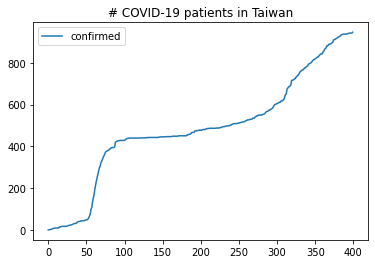

In [ ]:
import matplotlib.pyplot as plt

plt.plot(confirmed, label="confirmed")
plt.legend(loc="best")
plt.title("# COVID-19 patients in Taiwan")
plt.show()

<h2>Data Splitting</h2>

In a time-series forecasting scenario, we need some labeled data to evaluate the model performance.
<br>
Therefore, I will split the 400 data into 350 for training and 50 for testing.

In [ ]:
train_data, test_data = confirmed[:350], confirmed[350:]
train_data.shape, test_data.shape

((350,), (50,))

Text(0.5, 1.0, 'Test Data')

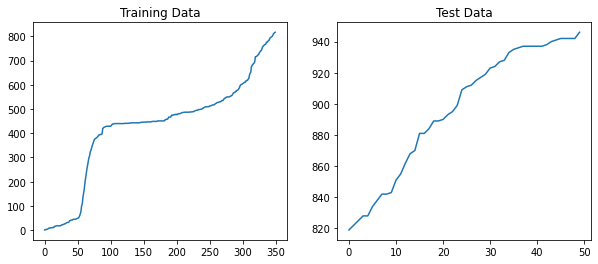

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(10)
axes[0].plot(train_data)
axes[0].set_title("Training Data")
axes[1].plot(test_data)
axes[1].set_title("Test Data")

<h2>Model 1: Decomposition + Smoothing</h2>

Generally, models perform better if we can first remove known sources of variation such as trend and seasonality. The main motivation for doing decomposition is to improve model performance.

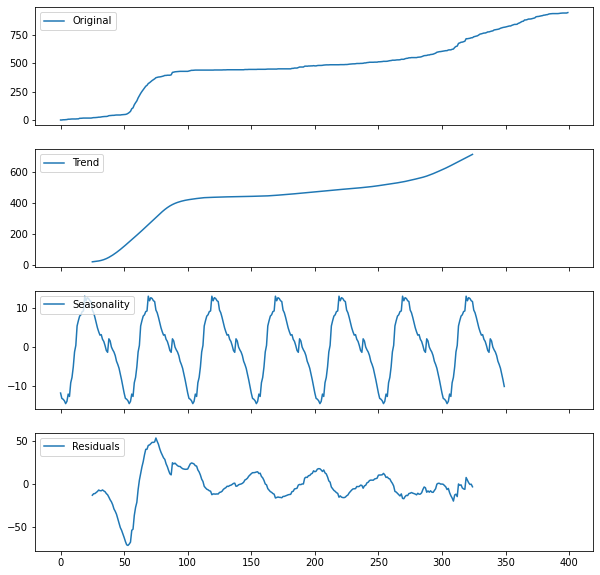

In [ ]:
ss_decomposition = seasonal_decompose(x=train_data, model="additive", freq=50)
trend = ss_decomposition.trend
seasonal = ss_decomposition.seasonal
residual = ss_decomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)

axes[0].plot(confirmed, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(residual, label='Residuals')
axes[3].legend(loc='upper left')

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, _, _, _, _ = adfuller(residual[25:-25])
pvalue

0.000488524285976228

Since the p-value in the adfuller test is smaller than 0.05, we reject the null hypothesis that the residual series is non-stationary.
<br>
Therefore, **the residual series is stationary,** and we can step further.

To make prediction, we assume that:
<ol>
  <li>The trend will continue</li>
  <li>The seasonality will be repeated</li>
  <li>The residuals still have zero mean and vairance, which can be ignored</li>
</ol>

Text(0.5, 1.0, 'Decomposition + Smoothing')

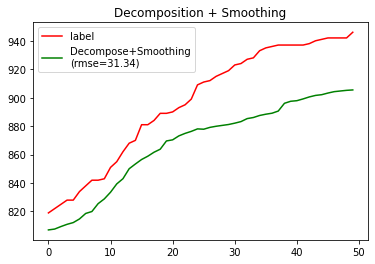

In [ ]:
slope = (trend.values[-50]-trend.values[50])/(len(trend)-100)

predict_trend = np.arange(1,51)*slope + train_data.values[-1]
predict_seasonal = seasonal.values[:50]
predict_residual = np.zeros(50)
predict_desm = predict_trend + predict_seasonal + predict_residual

rmse = np.sqrt(np.mean((predict_desm-test_data)**2))

plt.plot(range(50), test_data, label="label", color="r")
plt.plot(range(50), predict_desm, label="Decompose+Smoothing\n(rmse={:.2f})".format(rmse), color="g")
plt.legend(loc="best")
plt.title("Decomposition + Smoothing")

We see the RMSE is 31.34. This performance will further become our baseline model.

<h2>Model 2: ARIMA</h2>

ARIMA stands for Auto-Regressive Integrated Moving Average, and it is composed of three modules: AR Model, Integrated Component, and MA Model.
<br>
For simplicity, I don't consider the MA model here, so the AR and Integrated Component will require us to tune some parameters. At first, I try the (3,1,0) configuration:

Text(0.5, 1.0, 'Test Set Performance')

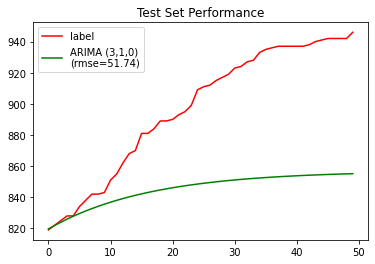

In [ ]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(train_data, order=(3,1,0)).fit(trend="nc")
predict_ar1 = model.forecast(steps=50)[0]
rmse = np.sqrt(np.mean((predict_ar-test_data)**2))

plt.plot(range(50), test_data, label="label", color="r")
plt.plot(range(50), predict_ar1, label="ARIMA (3,1,0)\n(rmse={:.2f})".format(rmse), color="g")
plt.legend(loc="best")
plt.title("Test Set Performance")

However, the performance is very low compared to the Decomposition+Smoothing method. Therefore, I try different hyperparameters and figure out that using lag-2 difference will turn out to boost the performance significantly!

Text(0.5, 1.0, 'Test Set Performance')

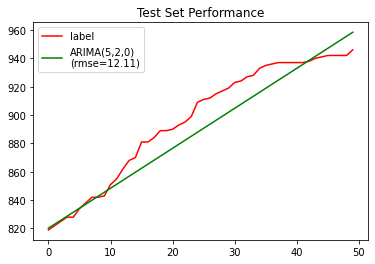

In [ ]:
model = sm.tsa.ARIMA(train_data, order=(3,2,0)).fit(trend="nc")
predict_ar2 = model.forecast(steps=50)[0]
rmse = np.sqrt(np.mean((predict_ar2-test_data)**2))

plt.plot(range(50), test_data, label="label", color="r")
plt.plot(range(50), predict_ar2, label="ARIMA(5,2,0)\n(rmse={:.2f})".format(rmse), color="g")
plt.legend(loc="best")
plt.title("Test Set Performance")


Now, 12.11 is significantly lower than 31.34 (performance of Decomposition+Smoothing). Though ARIMA yields lower RMSE, the optimal hyperparameters are required to be tuned manually, which needs extra efforts.

<h2>Model 3: LSTM</h2>

In this part, I will use some deep learning techniques.
<br>
To train the deep neural network properly, we need to pre-process the data, such as min-max scaling.

In [ ]:
confirmed = confirmed.values

Text(0.5, 1.0, 'Normalized Confirmed Data')

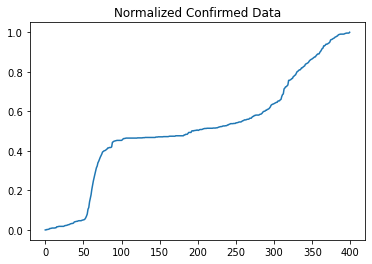

In [ ]:
norm_data = (confirmed-min(confirmed)) / (max(confirmed)-min(confirmed))
plt.plot(norm_data)
plt.title("Normalized Confirmed Data")

After pre-processing, the data will be split into train/test again.

In [ ]:
train_norm, test_norm = norm_data[:350], norm_data[350:]
train_norm.shape, test_norm.shape

((350,), (50,))

In [ ]:
train_X, train_y = [], []
for i in range(0, train_norm.shape[0]-50, 5): 
  train_X.append(train_norm[i:i+50])
  train_y.append(train_norm[i+50])

train_X = np.expand_dims(np.array(train_X), axis=2)
train_y = np.array(train_y)

train_X.shape, train_y.shape

((60, 50, 1), (60,))

Here is our LSTM model, which contains 30 cell units, and 1 dense layer to output a single value.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(30, input_shape=(train_X.shape[1],1)))
model.add(Dense(1))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 30)                3840      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=500, batch_size=32, verbose=0)
history.history["loss"][-5:]

[0.0001787654764484614,
 0.0001761017629178241,
 0.00017647411732468754,
 0.00017281361215282232,
 0.00017269041563849896]

The training loss is converge. Next, we'll inference the trained LSTM to the test set.

Text(0.5, 1.0, 'Prediction Before Scaling')

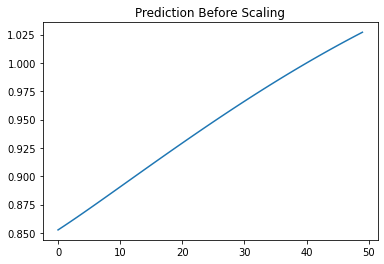

In [ ]:
X_init = train_X[-1,:,:].reshape(1,-1,1)

predict = []
for _ in range(50):
  output = model.predict(X_init)
  predict.append(output)
  X_init[:,:-1,:] = X_init[:,1:,:]
  X_init[:,-1,:] = output

predict = np.array(predict).reshape(-1,1)
plt.plot(predict)
plt.title("Prediction Before Scaling")

However, the output is nearly ranged from (0,1), which makes us hard to compare the performance. Therefore, we need to scale-up the predicted values.

Text(0.5, 1.0, 'LSTM-30')

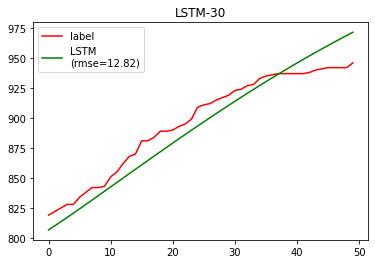

In [ ]:
predict_lstm = (predict * (max(confirmed)-min(confirmed)) + min(confirmed)).squeeze()
rmse = np.sqrt(np.mean((predict_lstm-test_data)**2))

plt.plot(range(50), test_data, label="label", color="r")
plt.plot(range(50), predict_lstm, label="LSTM\n(rmse={:.2f})".format(rmse), color="g")
plt.legend(loc="best")
plt.title("LSTM-30")

We get RMSE=12.82 for LSTM, which is slightly lower than the performance of ARIMA.
<br>
However, LSTM is able to learn how to incorporate series characteristics automatically, which is much easier to be tuned well.

<h2>Conclusion</h2>

In this project, I extracted the COVID-19 spread dataset, and build forecasting models including Decomposition+Smoothing, ARIMA, and LSTM.
<ol>
  <li><b>Decomposition+Smoothing</b> yields the lowest performance because we only consider the trend and seasonality from the training data and then make the same assumption to the test data.</li>
  <li><b>ARIMA</b> yields the highest performance, but the best (p,d,q) should be tuned manually.</li>
  <li><b>LSTM</b> yields high performance as well, and we just need to clarify the number of cell units. However, the training time is the longest.</li>

<h2>Next Steps</h2>



1.  Actually, there are still many attributes not being used in this project (such as location, number of recovered, and number of deaths). To build a model which captures every aspect, required more time for investigation.
2.   LSTM should be able to capture very complex patterns and can simultaneously model many related series instead of treating each separately. In some more complex scenarios, I believe LSTM can yield better performance than ARIMA.

